Processing window size ±0
Processing window size ±1
Processing window size ±2
Processing window size ±4
Processing window size ±8
Processing window size ±16


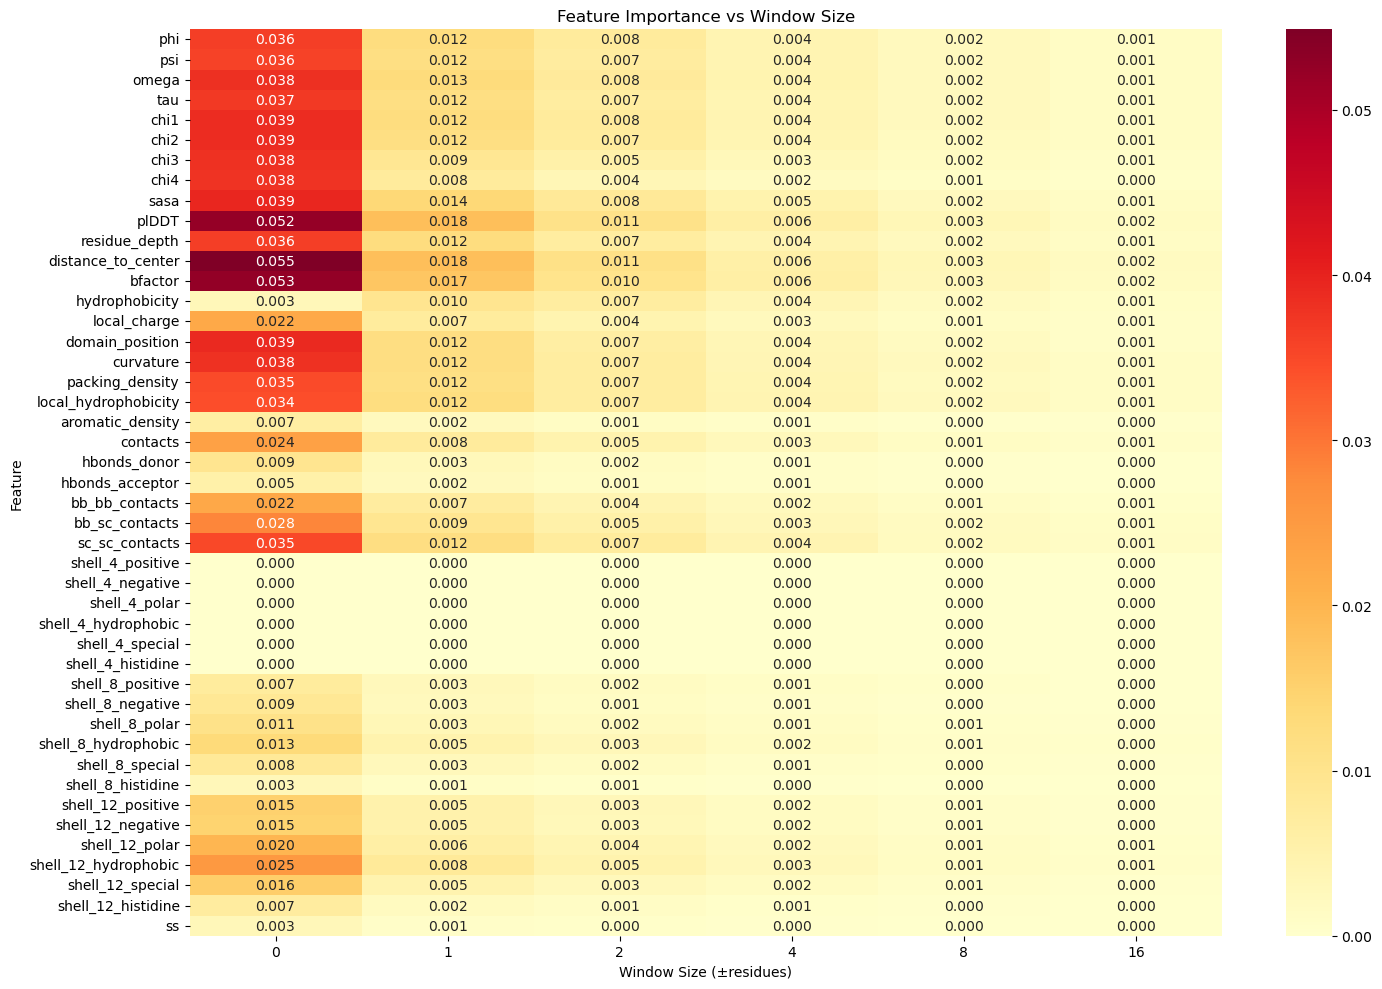


Top 10 features for window size ±0:
distance_to_center: 0.0549
bfactor: 0.0527
plDDT: 0.0525
sasa: 0.0395
domain_position: 0.0392
chi2: 0.0387
chi1: 0.0387
omega: 0.0382
chi3: 0.0381
curvature: 0.0379

Top 10 features for window size ±1:
distance_to_center: 0.0183
plDDT: 0.0183
bfactor: 0.0171
sasa: 0.0137
omega: 0.0128
phi: 0.0124
chi1: 0.0124
residue_depth: 0.0123
local_hydrophobicity: 0.0120
domain_position: 0.0120

Top 10 features for window size ±2:
distance_to_center: 0.0110
plDDT: 0.0106
bfactor: 0.0101
sasa: 0.0082
omega: 0.0078
chi1: 0.0076
phi: 0.0075
chi2: 0.0074
sc_sc_contacts: 0.0073
psi: 0.0072

Top 10 features for window size ±4:
plDDT: 0.0062
bfactor: 0.0061
distance_to_center: 0.0059
sasa: 0.0047
omega: 0.0043
chi1: 0.0043
phi: 0.0042
psi: 0.0041
sc_sc_contacts: 0.0041
local_hydrophobicity: 0.0041

Top 10 features for window size ±8:
distance_to_center: 0.0033
plDDT: 0.0033
bfactor: 0.0032
sasa: 0.0023
omega: 0.0023
phi: 0.0023
chi1: 0.0022
residue_depth: 0.0022
curva

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
df = pd.read_csv('../data/processed_features_train_latest.csv')

# Function to convert string of numbers to list
def convert_string_to_list(s):
    try:
        return [float(x.strip()) for x in s.strip('[]').split(',')]
    except:
        return s

# Process features with multiple values (window size feature)
def process_feature(df, feature_name):
    # Get middle position (K position)
    window_size = 16  # since we have ±16 window
    middle_pos = window_size
    
    # Convert string representation to list for numerical features
    if df[feature_name].dtype == 'object' and feature_name not in ['sequence', 'ss', 'entry']:
        df[feature_name] = df[feature_name].apply(convert_string_to_list)
    
    return df

# Group features by type
discrete_features = ['charge', 'ss']  # Categorical/discrete values
binary_features = ['ss_in_middle']  # Binary 0/1 values
count_features = [
    'contacts', 'hbonds_donor', 'hbonds_acceptor',
    'bb_bb_contacts', 'bb_sc_contacts', 'sc_sc_contacts',
    'shell_4_positive', 'shell_4_negative', 'shell_4_polar',
    'shell_4_hydrophobic', 'shell_4_special', 'shell_4_histidine',
    'shell_8_positive', 'shell_8_negative', 'shell_8_polar',
    'shell_8_hydrophobic', 'shell_8_special', 'shell_8_histidine',
    'shell_12_positive', 'shell_12_negative', 'shell_12_polar',
    'shell_12_hydrophobic', 'shell_12_special', 'shell_12_histidine'
]
continuous_features = [
    'phi', 'psi', 'omega', 'tau', 
    'chi1', 'chi2', 'chi3', 'chi4',
    'sasa', 'plDDT', 'residue_depth', 'distance_to_center',
    'bfactor', 'hydrophobicity', 'local_charge',
    'domain_position', 'curvature', 'packing_density',
    'local_hydrophobicity', 'aromatic_density'
]

# Process each feature
for feature in discrete_features + binary_features + count_features + continuous_features:
    df = process_feature(df, feature)

# Calculate average feature importance
def get_feature_importance(df, window_size=0):
    """
    Calculate feature importance for a specific window size
    window_size: number of residues on each side (0 means only the K position)
    """
    # Prepare data
    X_processed = []
    feature_names = []
    
    # Process each feature type
    for feature in continuous_features:
        positions = list(range(16-window_size, 17+window_size))
        for pos in positions:
            values = df[feature].apply(lambda x: x[pos])
            X_processed.append(values)
            feature_names.append(f"{feature}_{pos-16}")
    
    for feature in count_features:
        positions = list(range(16-window_size, 17+window_size))
        for pos in positions:
            values = df[feature].apply(lambda x: x[pos])
            X_processed.append(values)
            feature_names.append(f"{feature}_{pos-16}")
    
    for feature in discrete_features:
        if feature == 'ss':
            # One-hot encode secondary structure
            positions = list(range(16-window_size, 17+window_size))
            for pos in positions:
                ss_values = df[feature].apply(lambda x: x[pos])
                for ss_type in ['H', 'E', 'L']:
                    X_processed.append((ss_values == ss_type).astype(int))
                    feature_names.append(f"{feature}_{ss_type}_{pos-16}")
        else:
            positions = list(range(16-window_size, 17+window_size))
            for pos in positions:
                values = df[feature].apply(lambda x: x[pos])
                X_processed.append(values)
                feature_names.append(f"{feature}_{pos-16}")

    # Convert to numpy array
    X = np.array(X_processed).T
    y = df['label'].values
    
    # Scale numeric features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Get feature importance
    importance = rf.feature_importances_
    
    # Aggregate importance by feature type
    feature_importance = {}
    for feat_type in continuous_features + count_features + ['ss']:
        if feat_type == 'ss':
            mask = [f.startswith('ss_') for f in feature_names]
        else:
            mask = [f.startswith(feat_type + '_') for f in feature_names]
        importance_values = importance[mask]
        feature_importance[feat_type] = np.mean(importance_values)
    
    return feature_importance

# Calculate importance for different window sizes
window_sizes = [0, 1, 2, 4, 8, 16]  # Example window sizes
all_importances = {}

for size in window_sizes:
    print(f"Processing window size ±{size}")
    importance = get_feature_importance(df, size)
    all_importances[size] = importance

# Plot results
plt.figure(figsize=(15, 10))
results_df = pd.DataFrame(all_importances)
sns.heatmap(results_df, annot=True, fmt='.3f', cmap='YlOrRd')
plt.title('Feature Importance vs Window Size')
plt.xlabel('Window Size (±residues)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print top features for each window size
for size in window_sizes:
    print(f"\nTop 10 features for window size ±{size}:")
    importance = all_importances[size]
    sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    for feature, imp in sorted_features[:10]:
        print(f"{feature}: {imp:.4f}")

Training Set Label Distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Percentage:
label
1    51.887006
0    48.112994
Name: proportion, dtype: float64
Processing window size ±0
Processing window size ±1
Processing window size ±2
Processing window size ±4
Processing window size ±8
Processing window size ±16


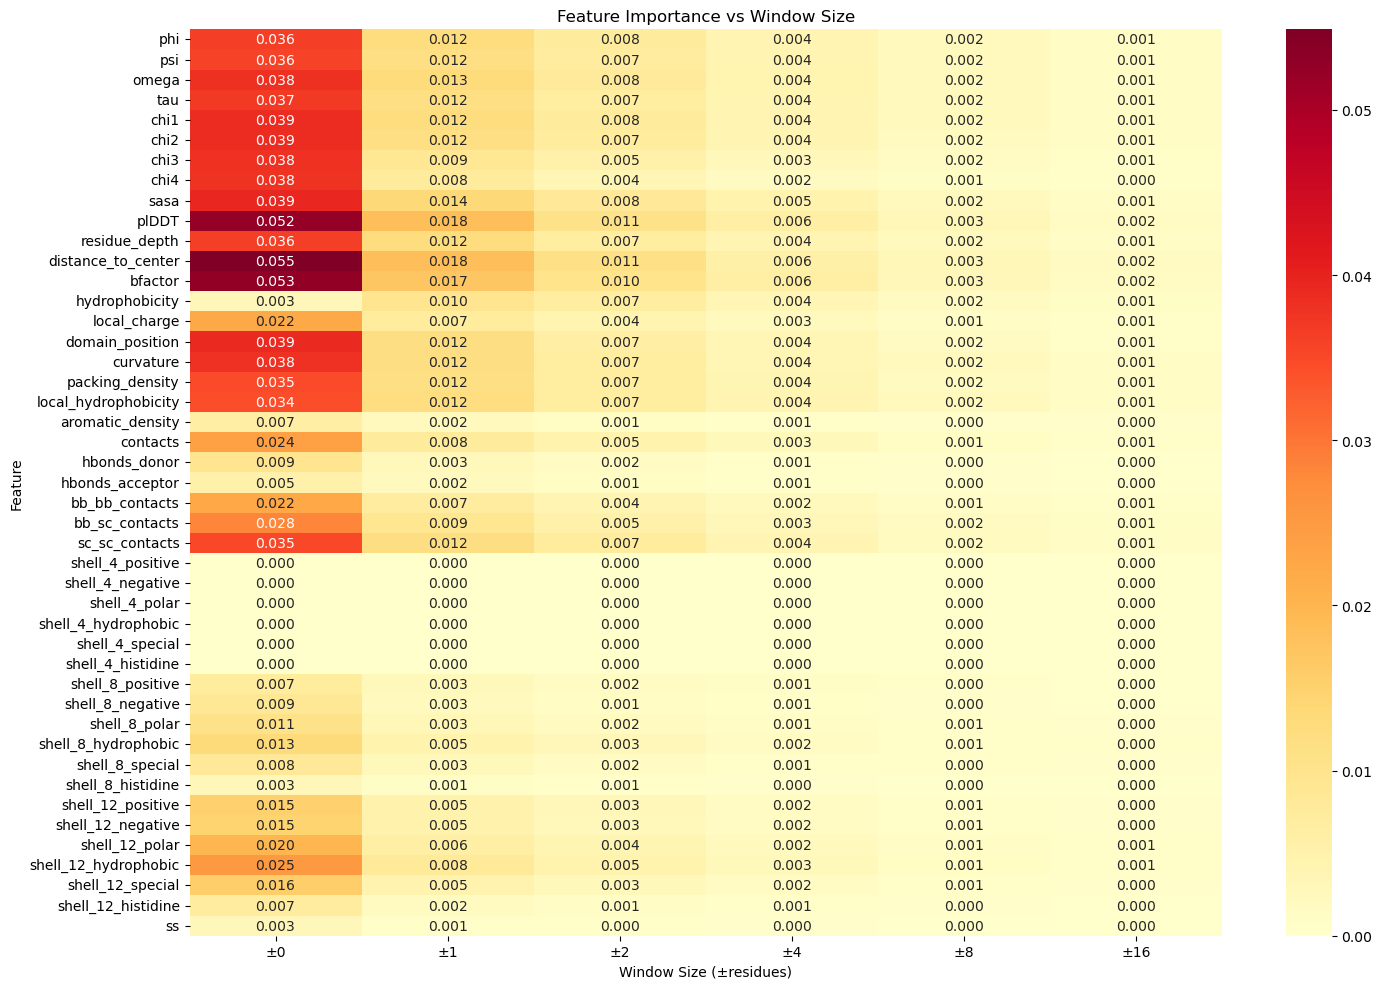


Top 10 features for window size ±0:
distance_to_center: 0.0549
bfactor: 0.0527
plDDT: 0.0525
sasa: 0.0395
domain_position: 0.0392
chi2: 0.0387
chi1: 0.0387
omega: 0.0382
chi3: 0.0381
curvature: 0.0379

Top 10 features for window size ±1:
distance_to_center: 0.0183
plDDT: 0.0183
bfactor: 0.0171
sasa: 0.0137
omega: 0.0128
phi: 0.0124
chi1: 0.0124
residue_depth: 0.0123
local_hydrophobicity: 0.0120
domain_position: 0.0120

Top 10 features for window size ±2:
distance_to_center: 0.0110
plDDT: 0.0106
bfactor: 0.0101
sasa: 0.0082
omega: 0.0078
chi1: 0.0076
phi: 0.0075
chi2: 0.0074
sc_sc_contacts: 0.0073
psi: 0.0072

Top 10 features for window size ±4:
plDDT: 0.0062
bfactor: 0.0061
distance_to_center: 0.0059
sasa: 0.0047
omega: 0.0043
chi1: 0.0043
phi: 0.0042
psi: 0.0041
sc_sc_contacts: 0.0041
local_hydrophobicity: 0.0041

Top 10 features for window size ±8:
distance_to_center: 0.0033
plDDT: 0.0033
bfactor: 0.0032
sasa: 0.0023
omega: 0.0023
phi: 0.0023
chi1: 0.0022
residue_depth: 0.0022
curva

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Read training data
train_df = pd.read_csv('../data/processed_features_train_latest.csv')

# Print basic statistics about labels in training set
print("Training Set Label Distribution:")
print(train_df['label'].value_counts())
print("\nPercentage:")
print(train_df['label'].value_counts(normalize=True) * 100)

# Function to convert string of numbers to list
def convert_string_to_list(s):
    try:
        return [float(x.strip()) for x in s.strip('[]').split(',')]
    except:
        return s

# Process features with multiple values (window size feature)
def process_feature(df, feature_name):
    # Get middle position (K position)
    window_size = 16  # since we have ±16 window
    middle_pos = window_size
    
    # Convert string representation to list for numerical features
    if df[feature_name].dtype == 'object' and feature_name not in ['sequence', 'ss', 'entry']:
        df[feature_name] = df[feature_name].apply(convert_string_to_list)
    
    return df

# Group features by type
discrete_features = ['charge', 'ss']  # Categorical/discrete values
binary_features = ['ss_in_middle']  # Binary 0/1 values
count_features = [
    'contacts', 'hbonds_donor', 'hbonds_acceptor',
    'bb_bb_contacts', 'bb_sc_contacts', 'sc_sc_contacts',
    'shell_4_positive', 'shell_4_negative', 'shell_4_polar',
    'shell_4_hydrophobic', 'shell_4_special', 'shell_4_histidine',
    'shell_8_positive', 'shell_8_negative', 'shell_8_polar',
    'shell_8_hydrophobic', 'shell_8_special', 'shell_8_histidine',
    'shell_12_positive', 'shell_12_negative', 'shell_12_polar',
    'shell_12_hydrophobic', 'shell_12_special', 'shell_12_histidine'
]
continuous_features = [
    'phi', 'psi', 'omega', 'tau', 
    'chi1', 'chi2', 'chi3', 'chi4',
    'sasa', 'plDDT', 'residue_depth', 'distance_to_center',
    'bfactor', 'hydrophobicity', 'local_charge',
    'domain_position', 'curvature', 'packing_density',
    'local_hydrophobicity', 'aromatic_density'
]

# Process each feature
for feature in discrete_features + binary_features + count_features + continuous_features:
    train_df = process_feature(train_df, feature)

# Calculate average feature importance
def get_feature_importance(df, window_size=0):
    """
    Calculate feature importance for a specific window size
    window_size: number of residues on each side (0 means only the K position)
    """
    # Prepare data
    X_processed = []
    feature_names = []
    
    # Process each feature type
    for feature in continuous_features:
        positions = list(range(16-window_size, 17+window_size))
        for pos in positions:
            values = df[feature].apply(lambda x: x[pos])
            X_processed.append(values)
            feature_names.append(f"{feature}_{pos-16}")
    
    for feature in count_features:
        positions = list(range(16-window_size, 17+window_size))
        for pos in positions:
            values = df[feature].apply(lambda x: x[pos])
            X_processed.append(values)
            feature_names.append(f"{feature}_{pos-16}")
    
    for feature in discrete_features:
        if feature == 'ss':
            # One-hot encode secondary structure
            positions = list(range(16-window_size, 17+window_size))
            for pos in positions:
                ss_values = df[feature].apply(lambda x: x[pos])
                for ss_type in ['H', 'E', 'L']:
                    X_processed.append((ss_values == ss_type).astype(int))
                    feature_names.append(f"{feature}_{ss_type}_{pos-16}")
        else:
            positions = list(range(16-window_size, 17+window_size))
            for pos in positions:
                values = df[feature].apply(lambda x: x[pos])
                X_processed.append(values)
                feature_names.append(f"{feature}_{pos-16}")

    # Convert to numpy array
    X = np.array(X_processed).T
    y = df['label'].values
    
    # Scale numeric features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Get feature importance
    importance = rf.feature_importances_
    
    # Aggregate importance by feature type
    feature_importance = {}
    for feat_type in continuous_features + count_features + ['ss']:
        if feat_type == 'ss':
            mask = [f.startswith('ss_') for f in feature_names]
        else:
            mask = [f.startswith(feat_type + '_') for f in feature_names]
        importance_values = importance[mask]
        feature_importance[feat_type] = np.mean(importance_values)
    
    return feature_importance

# Calculate importance for different window sizes
window_sizes = [0, 1, 2, 4, 8, 16]  # Example window sizes
all_importances = {}

for size in window_sizes:
    print(f"Processing window size ±{size}")
    importance = get_feature_importance(train_df, size)
    all_importances[size] = importance

# Plot results
plt.figure(figsize=(15, 10))
results_df = pd.DataFrame(all_importances)
results_df.columns = [f'±{size}' for size in window_sizes]
sns.heatmap(results_df, annot=True, fmt='.3f', cmap='YlOrRd')
plt.title('Feature Importance vs Window Size')
plt.xlabel('Window Size (±residues)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print top features for each window size
for size in window_sizes:
    print(f"\nTop 10 features for window size ±{size}:")
    importance = all_importances[size]
    sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    for feature, imp in sorted_features[:10]:
        print(f"{feature}: {imp:.4f}")

Training Set Label Distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Percentage:
label
1    51.887006
0    48.112994
Name: proportion, dtype: float64
Processing window size ±0
Processing window size ±1
Processing window size ±2
Processing window size ±4
Processing window size ±8
Processing window size ±16

Recommended window sizes for each feature (sorted by importance):

Feature | Optimal Window | Importance
--------------------------------------------------
distance_to_center             | ±0            | 0.0549
bfactor                        | ±0            | 0.0527
plDDT                          | ±0            | 0.0525
sasa                           | ±0            | 0.0395
domain_position                | ±0            | 0.0392
chi2                           | ±0            | 0.0387
chi1                           | ±0            | 0.0387
omega                          | ±0            | 0.0382
chi3                           | ±0            | 0.0381
curvature      

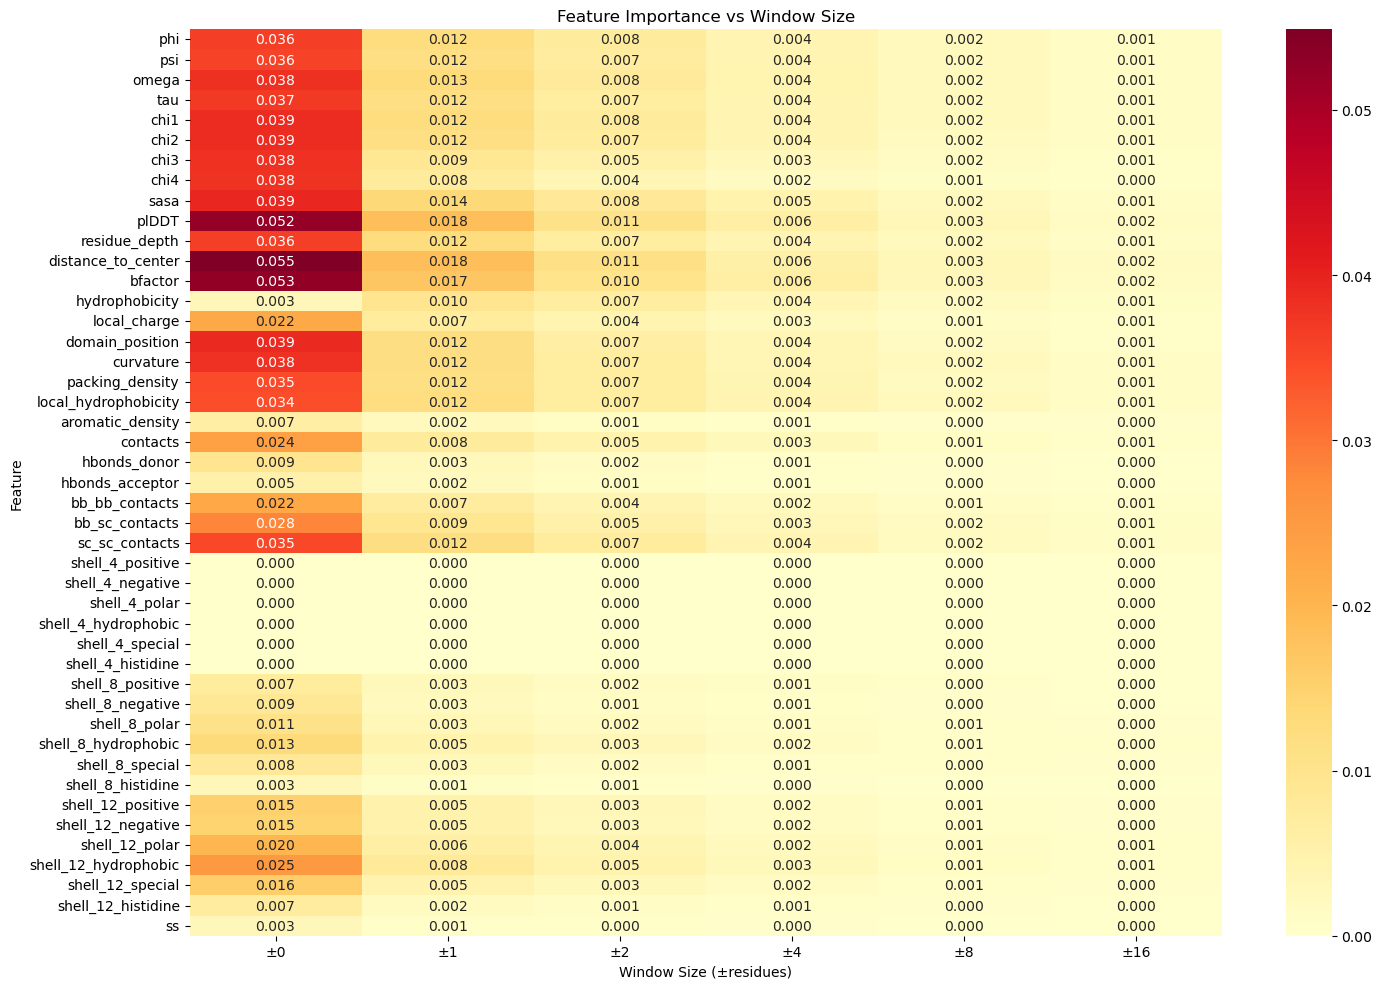

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Read training data
train_df = pd.read_csv('../data/processed_features_train_latest.csv')

# Print basic statistics about labels in training set
print("Training Set Label Distribution:")
print(train_df['label'].value_counts())
print("\nPercentage:")
print(train_df['label'].value_counts(normalize=True) * 100)

# Function to convert string of numbers to list
def convert_string_to_list(s):
    try:
        return [float(x.strip()) for x in s.strip('[]').split(',')]
    except:
        return s

# Process features with multiple values (window size feature)
def process_feature(df, feature_name):
    # Get middle position (K position)
    window_size = 16  # since we have ±16 window
    middle_pos = window_size
    
    # Convert string representation to list for numerical features
    if df[feature_name].dtype == 'object' and feature_name not in ['sequence', 'ss', 'entry']:
        df[feature_name] = df[feature_name].apply(convert_string_to_list)
    
    return df

# Group features by type
discrete_features = ['charge', 'ss']  # Categorical/discrete values
binary_features = ['ss_in_middle']  # Binary 0/1 values
count_features = [
    'contacts', 'hbonds_donor', 'hbonds_acceptor',
    'bb_bb_contacts', 'bb_sc_contacts', 'sc_sc_contacts',
    'shell_4_positive', 'shell_4_negative', 'shell_4_polar',
    'shell_4_hydrophobic', 'shell_4_special', 'shell_4_histidine',
    'shell_8_positive', 'shell_8_negative', 'shell_8_polar',
    'shell_8_hydrophobic', 'shell_8_special', 'shell_8_histidine',
    'shell_12_positive', 'shell_12_negative', 'shell_12_polar',
    'shell_12_hydrophobic', 'shell_12_special', 'shell_12_histidine'
]
continuous_features = [
    'phi', 'psi', 'omega', 'tau', 
    'chi1', 'chi2', 'chi3', 'chi4',
    'sasa', 'plDDT', 'residue_depth', 'distance_to_center',
    'bfactor', 'hydrophobicity', 'local_charge',
    'domain_position', 'curvature', 'packing_density',
    'local_hydrophobicity', 'aromatic_density'
]

# Process each feature
for feature in discrete_features + binary_features + count_features + continuous_features:
    train_df = process_feature(train_df, feature)

# Calculate average feature importance
def get_feature_importance(df, window_size=0):
    """
    Calculate feature importance for a specific window size
    window_size: number of residues on each side (0 means only the K position)
    """
    # Prepare data
    X_processed = []
    feature_names = []
    
    # Process each feature type
    for feature in continuous_features:
        positions = list(range(16-window_size, 17+window_size))
        for pos in positions:
            values = df[feature].apply(lambda x: x[pos])
            X_processed.append(values)
            feature_names.append(f"{feature}_{pos-16}")
    
    for feature in count_features:
        positions = list(range(16-window_size, 17+window_size))
        for pos in positions:
            values = df[feature].apply(lambda x: x[pos])
            X_processed.append(values)
            feature_names.append(f"{feature}_{pos-16}")
    
    for feature in discrete_features:
        if feature == 'ss':
            # One-hot encode secondary structure
            positions = list(range(16-window_size, 17+window_size))
            for pos in positions:
                ss_values = df[feature].apply(lambda x: x[pos])
                for ss_type in ['H', 'E', 'L']:
                    X_processed.append((ss_values == ss_type).astype(int))
                    feature_names.append(f"{feature}_{ss_type}_{pos-16}")
        else:
            positions = list(range(16-window_size, 17+window_size))
            for pos in positions:
                values = df[feature].apply(lambda x: x[pos])
                X_processed.append(values)
                feature_names.append(f"{feature}_{pos-16}")

    # Convert to numpy array
    X = np.array(X_processed).T
    y = df['label'].values
    
    # Scale numeric features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Get feature importance
    importance = rf.feature_importances_
    
    # Aggregate importance by feature type
    feature_importance = {}
    for feat_type in continuous_features + count_features + ['ss']:
        if feat_type == 'ss':
            mask = [f.startswith('ss_') for f in feature_names]
        else:
            mask = [f.startswith(feat_type + '_') for f in feature_names]
        importance_values = importance[mask]
        feature_importance[feat_type] = np.mean(importance_values)
    
    return feature_importance
# Calculate importance for different window sizes
window_sizes = [0, 1, 2, 4, 8, 16]
all_importances = {}

for size in window_sizes:
    print(f"Processing window size ±{size}")
    importance = get_feature_importance(train_df, size)
    all_importances[size] = importance

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(all_importances)
results_df.columns = [f'±{size}' for size in window_sizes]

# Find optimal window size for each feature
optimal_windows = {}
for feature in results_df.index:
    best_window = results_df.loc[feature].idxmax()
    best_importance = results_df.loc[feature].max()
    optimal_windows[feature] = (best_window, best_importance)

# Sort features by importance
sorted_features = sorted(optimal_windows.items(), key=lambda x: x[1][1], reverse=True)

# Print recommendations
print("\nRecommended window sizes for each feature (sorted by importance):")
print("\nFeature | Optimal Window | Importance")
print("-" * 50)
for feature, (window, importance) in sorted_features:
    print(f"{feature:<30} | {window:<13} | {importance:.4f}")

# Plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(results_df, annot=True, fmt='.3f', cmap='YlOrRd')
plt.title('Feature Importance vs Window Size')
plt.xlabel('Window Size (±residues)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Read training data
train_df = pd.read_csv('../data/processed_features_train_latest.csv')

# Group features by type
discrete_features = ['charge', 'ss']  # Categorical/discrete values
binary_features = ['ss_in_middle']  # Binary 0/1 values
count_features = [
    'contacts', 'hbonds_donor', 'hbonds_acceptor',
    'bb_bb_contacts', 'bb_sc_contacts', 'sc_sc_contacts',
    'shell_4_positive', 'shell_4_negative', 'shell_4_polar',
    'shell_4_hydrophobic', 'shell_4_special', 'shell_4_histidine',
    'shell_8_positive', 'shell_8_negative', 'shell_8_polar',
    'shell_8_hydrophobic', 'shell_8_special', 'shell_8_histidine',
    'shell_12_positive', 'shell_12_negative', 'shell_12_polar',
    'shell_12_hydrophobic', 'shell_12_special', 'shell_12_histidine'
]
continuous_features = [
    'phi', 'psi', 'omega', 'tau', 
    'chi1', 'chi2', 'chi3', 'chi4',
    'sasa', 'residue_depth', 'distance_to_center',
    'bfactor', 'hydrophobicity', 'local_charge',
    'domain_position', 'curvature', 'packing_density',
    'local_hydrophobicity', 'aromatic_density'
]  # Removed plDDT

# Function to convert string of numbers to list
def convert_string_to_list(s):
    try:
        return [float(x.strip()) for x in s.strip('[]').split(',')]
    except:
        return s

# Process features with multiple values (window size feature)
def process_feature(df, feature_name):
    # Get middle position (K position)
    window_size = 16  # since we have ±16 window
    middle_pos = window_size
    
    # Convert string representation to list for numerical features
    if df[feature_name].dtype == 'object' and feature_name not in ['sequence', 'ss', 'entry']:
        df[feature_name] = df[feature_name].apply(convert_string_to_list)
    
    return df

# Process each feature
for feature in discrete_features + binary_features + count_features + continuous_features:
    train_df = process_feature(train_df, feature)

# Calculate feature importance for different window sizes
def get_feature_importance(df, window_size=0):
    """
    Calculate feature importance for a specific window size
    window_size: number of residues on each side (0 means only the K position)
    """
    # Prepare data
    X_processed = []
    feature_names = []
    
    # Process each feature type
    for feature in continuous_features:
        positions = list(range(16-window_size, 17+window_size))
        for pos in positions:
            values = df[feature].apply(lambda x: x[pos])
            X_processed.append(values)
            feature_names.append(f"{feature}_{pos-16}")
    
    for feature in count_features:
        positions = list(range(16-window_size, 17+window_size))
        for pos in positions:
            values = df[feature].apply(lambda x: x[pos])
            X_processed.append(values)
            feature_names.append(f"{feature}_{pos-16}")
    
    for feature in discrete_features:
        if feature == 'ss':
            # One-hot encode secondary structure
            positions = list(range(16-window_size, 17+window_size))
            for pos in positions:
                ss_values = df[feature].apply(lambda x: x[pos])
                for ss_type in ['H', 'E', 'L']:
                    X_processed.append((ss_values == ss_type).astype(int))
                    feature_names.append(f"{feature}_{ss_type}_{pos-16}")
        else:
            positions = list(range(16-window_size, 17+window_size))
            for pos in positions:
                values = df[feature].apply(lambda x: x[pos])
                X_processed.append(values)
                feature_names.append(f"{feature}_{pos-16}")

    # Convert to numpy array
    X = np.array(X_processed).T
    y = df['label'].values
    
    # Scale numeric features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Train Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    # Get feature importance
    importance = rf.feature_importances_
    
    # Aggregate importance by feature type
    feature_importance = {}
    for feat_type in continuous_features + count_features + ['ss']:
        if feat_type == 'ss':
            mask = [f.startswith('ss_') for f in feature_names]
        else:
            mask = [f.startswith(feat_type + '_') for f in feature_names]
        importance_values = importance[mask]
        feature_importance[feat_type] = np.mean(importance_values)
    
    return feature_importance

# Calculate importance for different window sizes
window_sizes = [0, 1, 2, 4, 8, 16]
all_importances = {}

for size in window_sizes:
    print(f"Processing window size ±{size}")
    importance = get_feature_importance(train_df, size)
    all_importances[size] = importance

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(all_importances)
results_df.columns = [f'±{size}' for size in window_sizes]

# Find optimal window size for each feature
optimal_windows = {}
for feature in results_df.index:
    best_window = results_df.loc[feature].idxmax()
    best_importance = results_df.loc[feature].max()
    optimal_windows[feature] = (best_window, best_importance)

# Sort features by importance
sorted_features = sorted(optimal_windows.items(), key=lambda x: x[1][1], reverse=True)

# Print recommendations
print("\nRecommended window sizes for each feature (sorted by importance):")
print("\nFeature | Optimal Window | Importance")
print("-" * 50)
for feature, (window, importance) in sorted_features:
    print(f"{feature:<30} | {window:<13} | {importance:.4f}")

Processing window size ±0
Processing window size ±1
Processing window size ±2
Processing window size ±4
Processing window size ±8
Processing window size ±16

Recommended window sizes for each feature (sorted by importance):

Feature | Optimal Window | Importance
--------------------------------------------------
bfactor                        | ±0            | 0.0667
distance_to_center             | ±0            | 0.0580
sasa                           | ±0            | 0.0417
omega                          | ±0            | 0.0407
domain_position                | ±0            | 0.0406
chi2                           | ±0            | 0.0400
residue_depth                  | ±0            | 0.0398
chi1                           | ±0            | 0.0398
chi4                           | ±0            | 0.0397
chi3                           | ±0            | 0.0390
curvature                      | ±0            | 0.0387
psi                            | ±0            | 0.0383
phi           